**Instructions for running this notebook on Colab**
1. Run the cell below to download code from GitHub and install correct version of Python modules
2. Restart session so that Colab can use the newly installed modules rather than their previously installed versions
3. Run all cells

**Note: The training cell can be run only once. If you need to re-run the cell, restart session.**

In [ ]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'fp-solvers'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/fp-solvers.git
!pip install -r fp-solvers/requirements.txt 2> /dev/null

Cloning into 'sphere-fp'...
remote: Enumerating objects: 1811, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1811 (delta 61), reused 222 (delta 58), pack-reused 1582
Receiving objects: 100% (1811/1811), 194.81 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (815/815), done.
Updating files: 100% (1239/1239), done.


In [ ]:
# add modules folder to Python's search path
import sys
sys.path.insert(0, repo + '/modules')
# import the necessary modules
import numpy as np
import tensorflow as tf
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Define the equation through the $\mathcal L_{\log}$ operator**

In [ ]:
DTYPE = tf.float32
D = 1.0
dim = 6
ones = np.ones(dim)
domain = [-2. * ones, 2. * ones]
save_folder = '{}/ring-fp/data/{}D'.format(repo, dim)

@tf.function
def diff_log_op(f, x, y, x1, y1, x2, y2):
    z = 4.*(x**2 + y**2 - 1.) 
    z1 = 4.*(x1**2 + y1**2 - 1.)
    z2 = 4.*(x2**2 + y2**2 - 1.)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, x1, y1, x2, y2])
        f_ = f(x, y, x1, y1, x2, y2)
        f_x, f_y, f_x1, f_y1, f_x2, f_y2 = tape.gradient(f_, [x, y, x1, y1, x2, y2])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    f_x1x1 = tape.gradient(f_x1, x1)
    f_y1y1 = tape.gradient(f_y1, y1)
    f_x2x2 = tape.gradient(f_x2, x2)
    f_y2y2 = tape.gradient(f_y2, y2)
    return z*(x*f_x + y*f_y) + z1*(x1*f_x1 + y1*f_y1) + z2*(x2*f_x2 + y2*f_y2) + 4.*(z+ z1 + z2 + dim) + D*(f_x**2 + f_y**2 + f_xx + f_yy + f_x1**2 + f_y1**2 + f_x1x1 + f_y1y1 + f_x2**2 + f_y2**2 + f_x2x2 + f_y2y2) 

**Define the steady state $p_\infty(\mathbf x)$**

In [ ]:
from scipy.special import erf
import numpy as np

def p_inf2(x, y):
  Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
  return tf.exp(-(x**2 + y**2 - 1.)**2 / D) / Z 

def p_inf(x, y, x1, y1, x2, y2):
  return p_inf2(x, y) * p_inf2(x1, y1) * p_inf2(x2, y2)

**Set up experiment parameters and learn the stationary distribution**

In [ ]:
# For documentation on the lss module please refer to the GitHub repo: pinakm9/fp-solvers
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000], [5e-3, 1e-3, 5e-4, 1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype=DTYPE, name='ring{}D'.format(dim), diff_log_op=diff_log_op, optimizer=optimizer, domain=domain)
solver.learn(epochs = 800000, n_sample = 1000, save_folder=save_folder)

Streaming output truncated to the last 5000 lines.
750000    0.036804        22838.9040
750010    0.031006        22839.2010
750020    0.034808        22839.5071
750030    0.032767        22839.8132
750040    0.033753        22840.1111
750050    0.031743        22840.4134
750060    0.030676        22840.7070
750070    0.031267        22841.0086
750080    0.034361        22841.2969
750090    0.030981        22841.5952
750100    0.029438        22841.8983
750110    0.030293        22842.2308
750120    0.030253        22842.5585
750130    0.030864        22842.8749
750140    0.032545        22843.1873
750150    0.034585        22843.5074
750160    0.028771        22843.8025
750170    0.034253        22844.1009
750180    0.034733        22844.4010
750190    0.027923        22844.6993
750200    0.032459        22845.0054
750210    0.032190        22845.3056
750220    0.030411        22845.6050
750230    0.033072        22845.9006
750240    0.034782        22846.2020
750250    0.031966      

**Visualize the learned distribution**

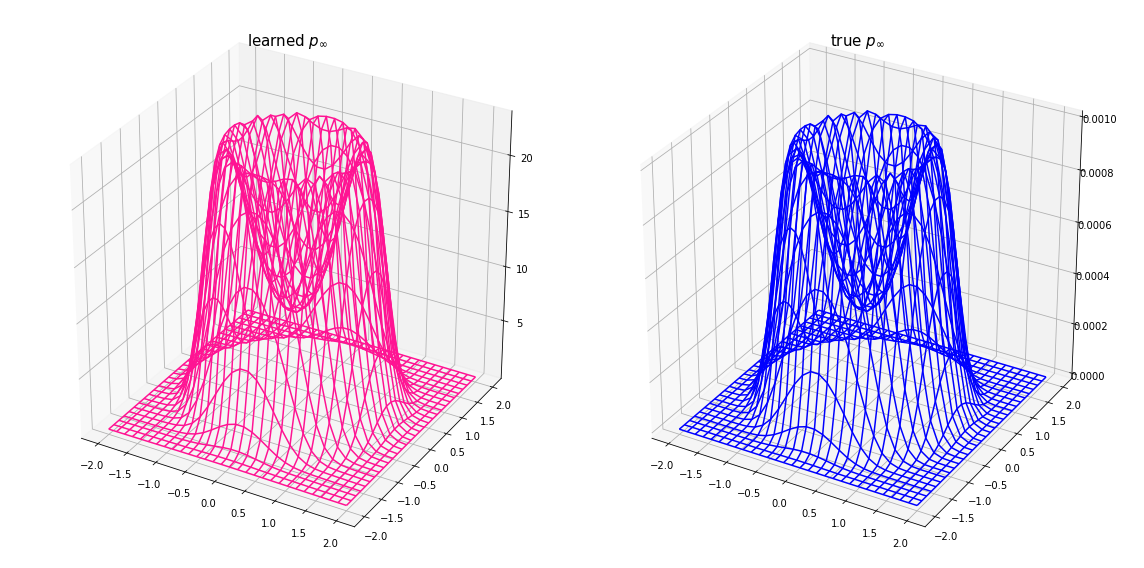

In [ ]:
import matplotlib.pyplot as plt

def plot_solutions(learned, true, resolution=30, low=domain[0], high=domain[1]):
  fig = plt.figure(figsize=(16, 8))
  ax_l = fig.add_subplot(121, projection='3d')
  ax_t = fig.add_subplot(122, projection='3d')
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_t = true(x, y).numpy()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  z_t = z_t.reshape(grid)
  ax_l.plot_wireframe(x, y, z_l, color='deeppink')
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  ax_t.plot_wireframe(x, y, z_t, color='blue')
  ax_t.set_title('true $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  
def learned(x, y):
  z = tf.zeros_like(x)
  zs = [z] * (dim - 2)
  return tf.exp(solver.net(x, y, *zs))

def true(x, y):
  z = tf.zeros_like(x)
  zs = [z] * (dim - 2)
  return p_inf(x, y, *zs)

plot_solutions(learned=learned, true=true)

**Investigate the size of $θ$**

In [ ]:
solver.net.summary()

Model: "sphere6D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTMForgetBlock (LSTMForget  multiple                 2600      
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 11400     
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 11400     
 Block)                                                          
                                                                 
 dense (Dense)               multiple                  51        
                                                                 
 batch_normalization (BatchN  multiple                 0 (unused)
 ormalization)                                            